In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.columns

Index(['SHIFT_ID', 'WORKER_ID', 'WORKPLACE_ID', 'SHIFT_START_AT',
       'SHIFT_CREATED_AT', 'OFFER_VIEWED_AT', 'DURATION', 'SLOT', 'CLAIMED_AT',
       'DELETED_AT', 'IS_VERIFIED', 'CANCELED_AT', 'IS_NCNS', 'PAY_RATE',
       'CHARGE_RATE'],
      dtype='object')

In [4]:
#Convert Date Columns to Datetime
date_columns = ['SHIFT_START_AT', 'SHIFT_CREATED_AT', 'OFFER_VIEWED_AT', 'CLAIMED_AT', 'DELETED_AT', 'CANCELED_AT']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

In [5]:
# Convert boolean columns
bool_columns = ['IS_VERIFIED', 'IS_NCNS']
for col in bool_columns:
    data[col] = data[col].astype(bool)

In [ ]:
#Working with Numeric Columns
numeric_columns = ['DURATION', 'PAY_RATE', 'CHARGE_RATE']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

,DURATION,PAY_RATE,CHARGE_RATE
0,8,21.29,29
1,9,23.23,30
2,6,21.97,30
3,8,19.05,28
4,8,22.13,24
...,...,...,...
266335,8,21.75,32
266336,8,22.21,24
266337,8,21.13,26
266338,8,19.90,28


In [ ]:
#Feature Engineering
data['IS_CLAIMED'] = data['CLAIMED_AT'].notnull()
data['TIME_TO_SHIFT_START'] = (data['SHIFT_START_AT'] - data['OFFER_VIEWED_AT']).dt.total_seconds() / 3600
data['TIME_TO_CLAIM'] = (data['CLAIMED_AT'] - data['OFFER_VIEWED_AT']).dt.total_seconds() / 3600

# Calculate Clipboard Health's margin
data['MARGIN'] = data['CHARGE_RATE'] - data['PAY_RATE']

# Extract day of week and hour from SHIFT_START_AT
data['DAY_OF_WEEK'] = data['SHIFT_START_AT'].dt.dayofweek
data['HOUR_OF_DAY'] = data['SHIFT_START_AT'].dt.hour

print("New columns added:")
print(data[['IS_CLAIMED', 'TIME_TO_SHIFT_START', 'TIME_TO_CLAIM', 'MARGIN', 'DAY_OF_WEEK', 'HOUR_OF_DAY']].head())


print("\nStatistics of new numeric columns:")
print(data[['TIME_TO_SHIFT_START', 'TIME_TO_CLAIM', 'MARGIN']].describe())


New columns added:
   IS_CLAIMED  TIME_TO_SHIFT_START  TIME_TO_CLAIM  MARGIN  DAY_OF_WEEK  \
0       False             1.688333            NaN    7.71            0   
1       False             9.175000            NaN    6.77            5   
2       False            10.929444            NaN    8.03            6   
3       False             9.670833            NaN    8.95            4   
4       False            68.723056            NaN    1.87            1   

   HOUR_OF_DAY  
0           23  
1           22  
2           15  
3           14  
4           21  

Statistics of new numeric columns:
       TIME_TO_SHIFT_START  TIME_TO_CLAIM         MARGIN
count        266340.000000   13064.000000  266340.000000
mean             78.880920       0.009703       7.346970
std             153.227686       0.014512       6.361104
min            -870.938056      -0.000278     -31.480000
25%               1.745556       0.001944       3.670000
50%              11.002917       0.005278       7.630000

In [9]:
data['IS_CLAIMED'] = data['CLAIMED_AT'].notnull()
data['TIME_TO_SHIFT_START'] = (data['SHIFT_START_AT'] - data['OFFER_VIEWED_AT']).dt.total_seconds() / 3600
data['TIME_TO_CLAIM'] = (data['CLAIMED_AT'] - data['OFFER_VIEWED_AT']).dt.total_seconds() / 3600
data['MARGIN'] = data['CHARGE_RATE'] - data['PAY_RATE']
data['DAY_OF_WEEK'] = data['SHIFT_START_AT'].dt.dayofweek
data['HOUR_OF_DAY'] = data['SHIFT_START_AT'].dt.hour

In [ ]:
#Data Validation and Cleaning
inconsistent_claims = data[(data['IS_CLAIMED'] == True) & (data['CLAIMED_AT'].isnull())].shape[0]
print(f"Inconsistent claims: {inconsistent_claims}")
data = data[data['TIME_TO_SHIFT_START'] >= 0]
data = data[data['MARGIN'] >= 0]
data['IS_VERIFIED'].fillna(False, inplace=True)
data['IS_NCNS'].fillna(False, inplace=True)
print("Final dataset shape:", data.shape)
print("\nFinal missing values:")
print(data.isnull().sum())


Inconsistent claims: 0
Final dataset shape: (241354, 21)

Final missing values:
SHIFT_ID                    0
WORKER_ID                   0
WORKPLACE_ID                0
SHIFT_START_AT              0
SHIFT_CREATED_AT            0
OFFER_VIEWED_AT             0
DURATION                    0
SLOT                        0
CLAIMED_AT             230746
DELETED_AT             187989
IS_VERIFIED                 0
CANCELED_AT            241070
IS_NCNS                     0
PAY_RATE                    0
CHARGE_RATE                 0
IS_CLAIMED                  0
TIME_TO_SHIFT_START         0
TIME_TO_CLAIM          230746
MARGIN                      0
DAY_OF_WEEK                 0
HOUR_OF_DAY                 0
dtype: int64


Claim Rate Distribution:
False    0.956048
True     0.043952
Name: IS_CLAIMED, dtype: float64


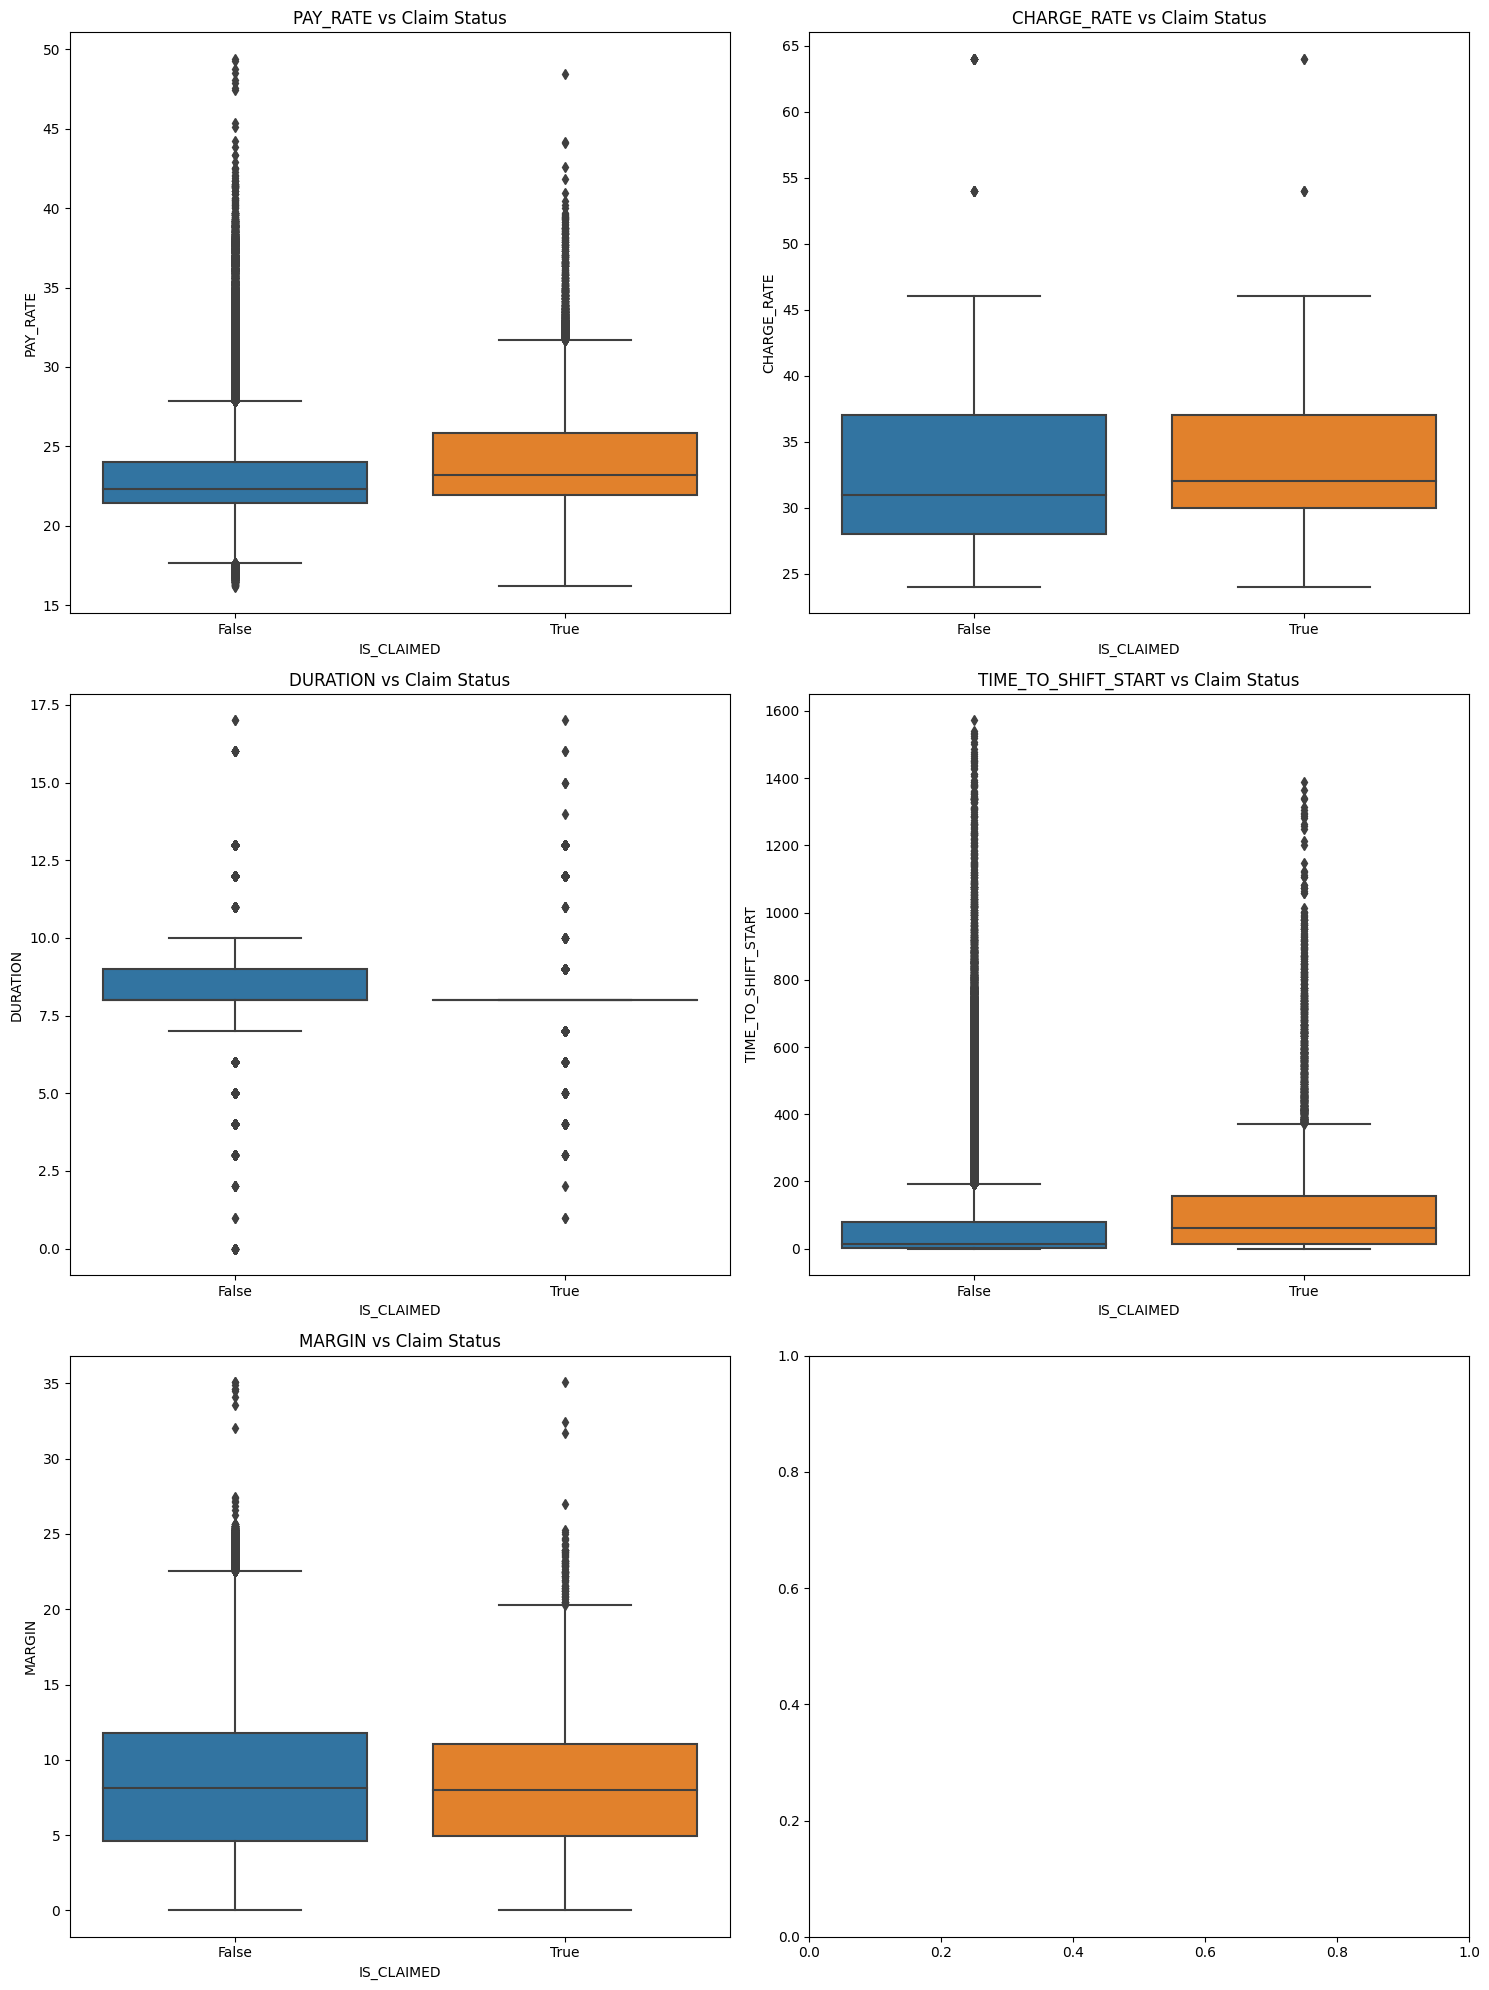

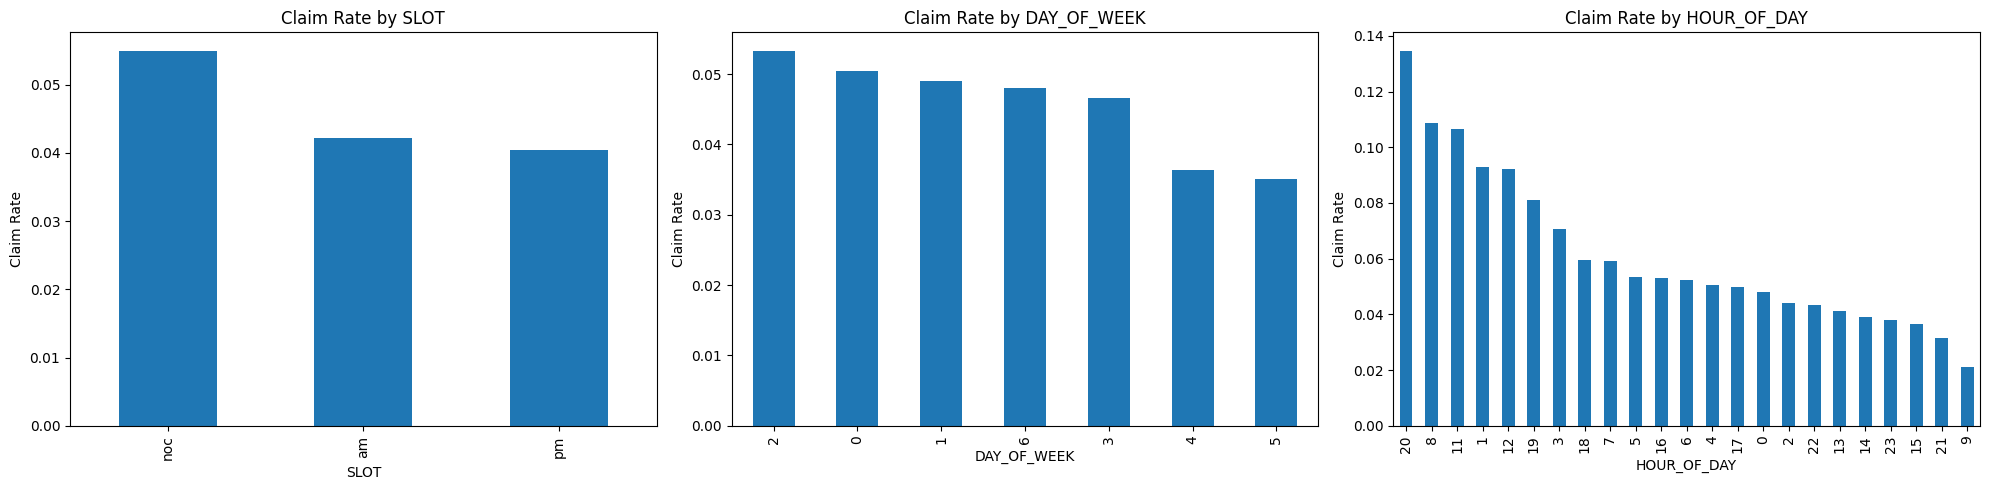


Top 10 Workplaces by Claim Rate (min 100 offers):
                              mean  count
WORKPLACE_ID                             
61c4d2a870dd500187dc98b1  0.273128    454
63517288a6775501b7fe1943  0.241206    199
614213db4592980166c594a7  0.235135    370
610c3e4bb0d8850166b2bd41  0.183724   2433
602db47f20bc3c0016d69381  0.174603    252
617195fe61cfc6016a47a1de  0.173090   1427
6197b1e6a706b30180020448  0.163721   1075
5ebf1773a253570017a27da2  0.159986   2944
62be1df86451d501bef14792  0.141663   2273
6203e9b58fa46801a9ed5f21  0.131062   2289

Top 10 Workers by Number of Offers Viewed:
                              mean  count
WORKER_ID                                
6247f3e6104f9501b130405d  0.007062    708
630c218f60c13c01b51b08e5  0.063665    644
664fba9a53f8a9d7f386d394  0.010118    593
61aaafb2b3c96c0185070c7a  0.005495    546
63be02e94b94c3b0e2614a73  0.011516    521
6281766759109301c15ef45a  0.104255    470
632f8b049603d78083671e58  0.061002    459
61f661b7e34c46018a7f7bc

In [ ]:
# Distribution of IS_CLAIMED
claim_distribution = data['IS_CLAIMED'].value_counts(normalize=True)
print("Claim Rate Distribution:")
print(claim_distribution)

# Visualize numeric features vs IS_CLAIMED
numeric_features = ['PAY_RATE', 'CHARGE_RATE', 'DURATION', 'TIME_TO_SHIFT_START', 'MARGIN']

fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.boxplot(x='IS_CLAIMED', y=feature, data=data, ax=axes[i])
    axes[i].set_title(f'{feature} vs Claim Status')

plt.tight_layout()
plt.show()

# Top workplaces by claim rate (minimum 100 offers)
top_workplaces = data.groupby('WORKPLACE_ID').filter(lambda x: len(x) >= 100).groupby('WORKPLACE_ID')['IS_CLAIMED'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(10)
print("\nTop 10 Workplaces by Claim Rate (min 100 offers):")
print(top_workplaces)

# Worker claim behavior
worker_behavior = data.groupby('WORKER_ID')['IS_CLAIMED'].agg(['mean', 'count']).sort_values('count', ascending=False).head(10)
print("\nTop 10 Workers by Number of Offers Viewed:")
print(worker_behavior)


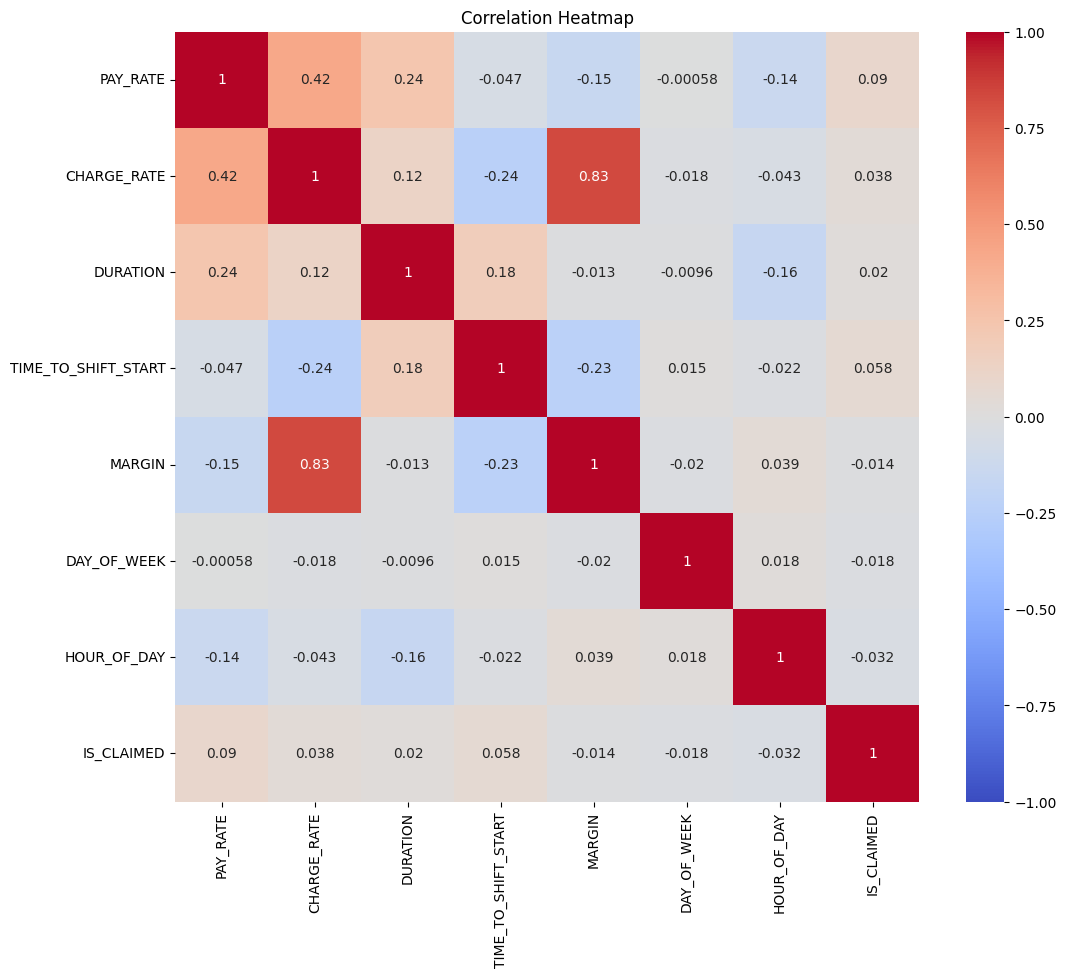

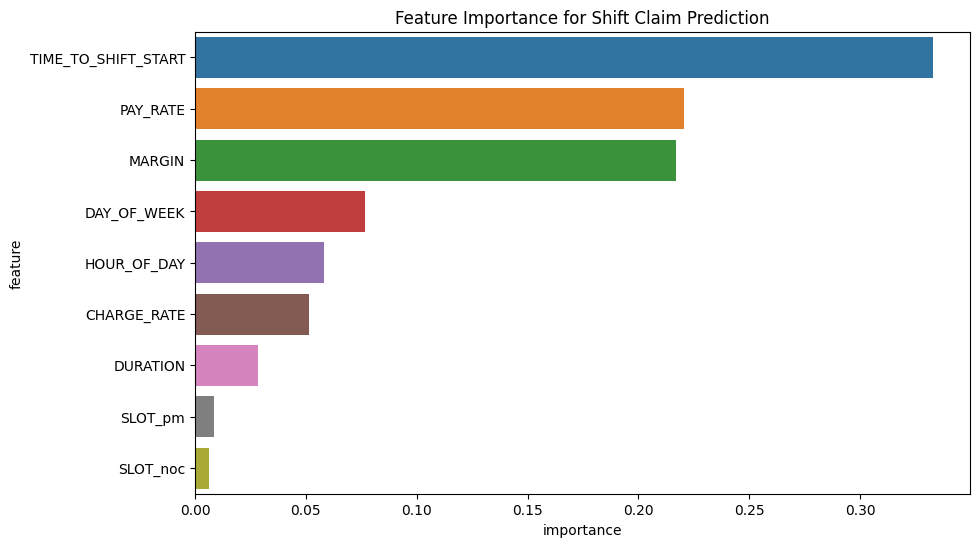

               feature  importance
3  TIME_TO_SHIFT_START    0.332901
0             PAY_RATE    0.220490
4               MARGIN    0.216751
5          DAY_OF_WEEK    0.076719
6          HOUR_OF_DAY    0.058067
1          CHARGE_RATE    0.051252
2             DURATION    0.028594
8              SLOT_pm    0.008731
7             SLOT_noc    0.006494


In [ ]:
#Correlation Heatmap
numeric_features = ['PAY_RATE', 'CHARGE_RATE', 'DURATION', 'TIME_TO_SHIFT_START', 'MARGIN', 'DAY_OF_WEEK', 'HOUR_OF_DAY']
correlation_matrix = data[numeric_features + ['IS_CLAIMED']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

X = data[numeric_features + ['SLOT']]
X = pd.get_dummies(X, columns=['SLOT'], drop_first=True)
y = data['IS_CLAIMED']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Shift Claim Prediction')
plt.show()

print(feature_importance)


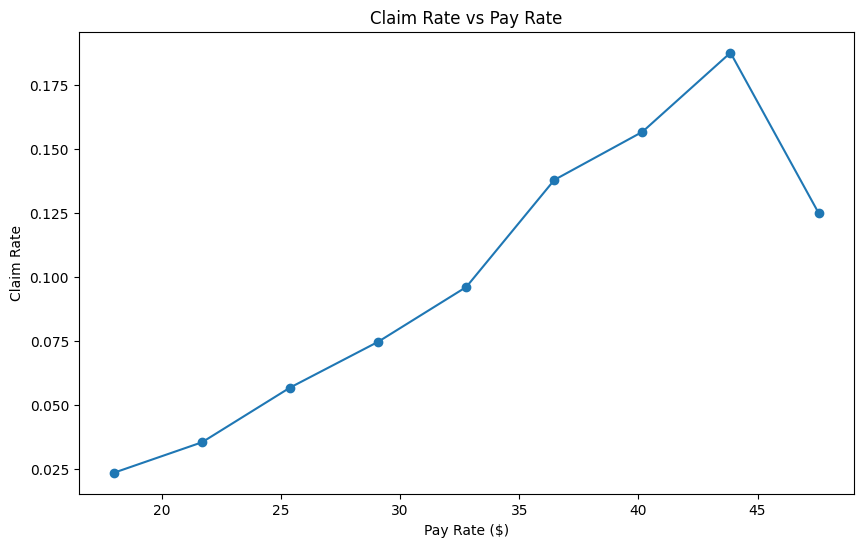

Price Elasticity: [ 0.00321556  0.00577602  0.00483309  0.00577855  0.01130408  0.00507367
  0.00835171 -0.01690712]


In [ ]:
# Calculating price elasticity
pay_rate_bins = np.linspace(data['PAY_RATE'].min(), data['PAY_RATE'].max(), 10)
claim_rates = []

for bin_start, bin_end in zip(pay_rate_bins[:-1], pay_rate_bins[1:]):
    bin_data = data[(data['PAY_RATE'] >= bin_start) & (data['PAY_RATE'] < bin_end)]
    claim_rate = bin_data['IS_CLAIMED'].mean()
    claim_rates.append(claim_rate)

plt.figure(figsize=(10, 6))
plt.plot((pay_rate_bins[:-1] + pay_rate_bins[1:]) / 2, claim_rates, marker='o')
plt.xlabel('Pay Rate ($)')
plt.ylabel('Claim Rate')
plt.title('Claim Rate vs Pay Rate')
plt.show()
elasticity = np.diff(claim_rates) / np.diff((pay_rate_bins[:-1] + pay_rate_bins[1:]) / 2)
print("Price Elasticity:", elasticity)


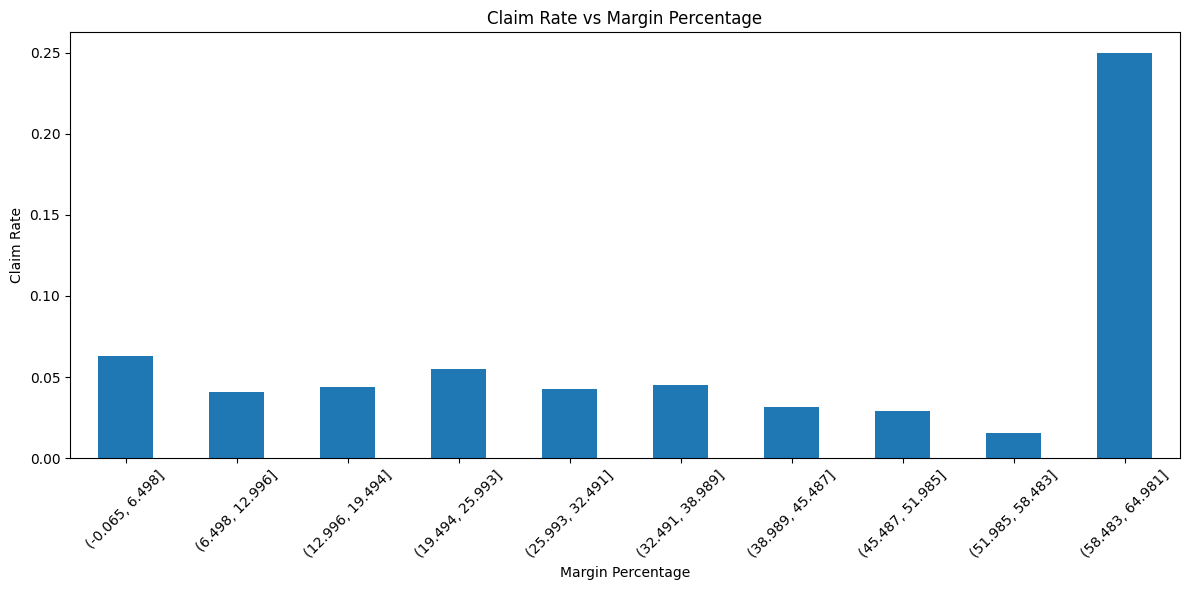

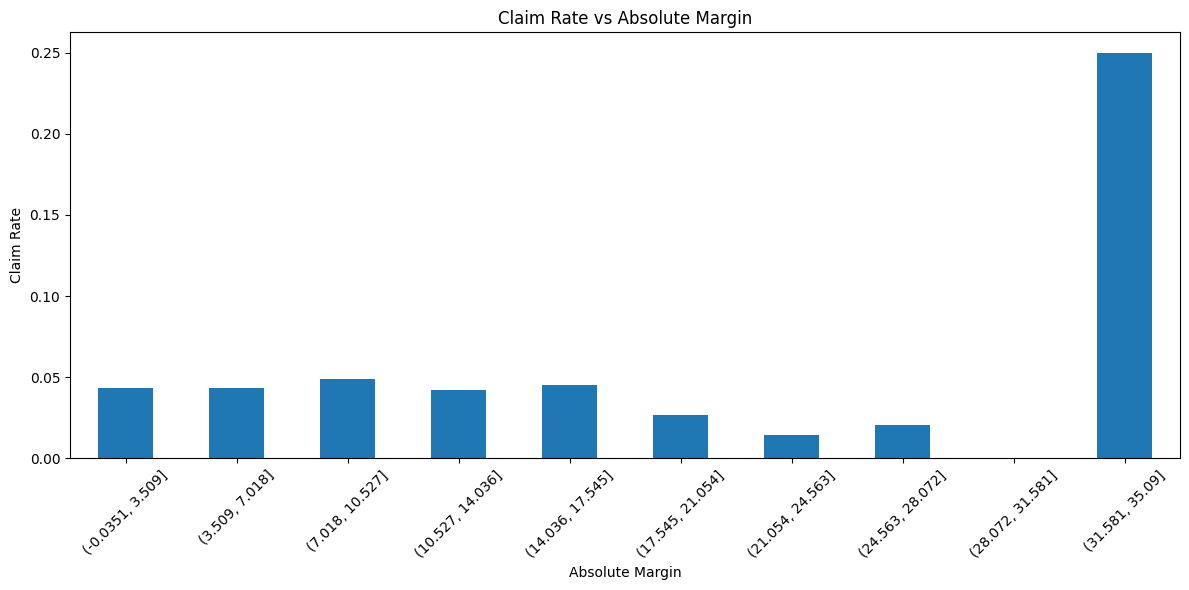

  MARGIN_PERCENTAGE  IS_CLAIMED  ABSOLUTE_MARGIN  CHARGE_RATE   PAY_RATE  \
0   (-0.065, 6.498]    0.062775         1.117958    26.877895  25.759937   
1   (6.498, 12.996]    0.040719         2.438630    25.748149  23.309519   
2  (12.996, 19.494]    0.044094         4.803250    29.327894  24.524644   
3  (19.494, 25.993]    0.055103         7.093027    30.710673  23.617646   
4  (25.993, 32.491]    0.042776         9.409888    32.091631  22.681743   
5  (32.491, 38.989]    0.044836        12.529603    35.281811  22.752208   
6  (38.989, 45.487]    0.031537        15.428883    36.941699  21.512815   
7  (45.487, 51.985]    0.029244        19.863269    40.864769  21.001500   
8  (51.985, 58.483]    0.015625        23.378949    44.040483  20.661534   
9  (58.483, 64.981]    0.250000        33.977500    54.000000  20.022500   

   DURATION  TOTAL_SHIFTS  CLAIMED_SHIFTS  TOTAL_REVENUE  TOTAL_PROFIT  
0  8.109474       24135.4     1515.102622   3.302402e+05  1.373600e+04  
1  8.066732      

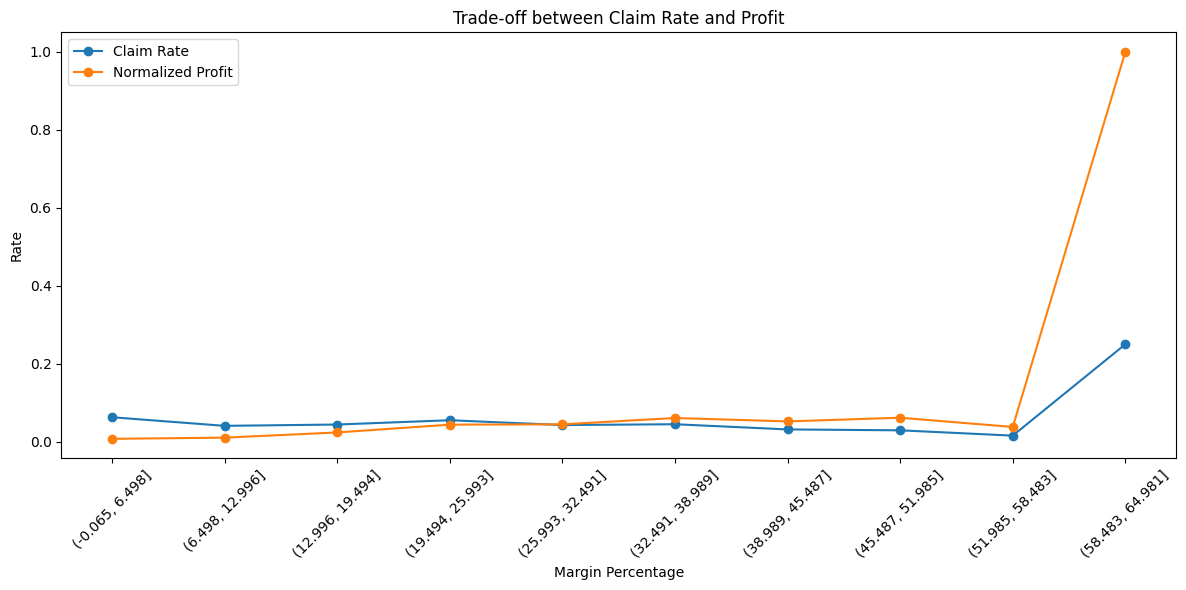

In [15]:
data['MARGIN_PERCENTAGE'] = (data['CHARGE_RATE'] - data['PAY_RATE']) / data['CHARGE_RATE'] * 100

# 2. Analyze the relationship between margin percentage and claim rate
margin_bins = pd.cut(data['MARGIN_PERCENTAGE'], bins=10)
margin_claim_rate = data.groupby(margin_bins)['IS_CLAIMED'].mean()

plt.figure(figsize=(12, 6))
margin_claim_rate.plot(kind='bar')
plt.title('Claim Rate vs Margin Percentage')
plt.xlabel('Margin Percentage')
plt.ylabel('Claim Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Analyze the relationship between absolute margin and claim rate
data['ABSOLUTE_MARGIN'] = data['CHARGE_RATE'] - data['PAY_RATE']
margin_bins = pd.cut(data['ABSOLUTE_MARGIN'], bins=10)
margin_claim_rate = data.groupby(margin_bins)['IS_CLAIMED'].mean()

plt.figure(figsize=(12, 6))
margin_claim_rate.plot(kind='bar')
plt.title('Claim Rate vs Absolute Margin')
plt.xlabel('Absolute Margin')
plt.ylabel('Claim Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Calculate total revenue and profit for different margin levels
margin_analysis = data.groupby(pd.cut(data['MARGIN_PERCENTAGE'], bins=10)).agg({
    'IS_CLAIMED': 'mean',
    'ABSOLUTE_MARGIN': 'mean',
    'CHARGE_RATE': 'mean',
    'PAY_RATE': 'mean',
    'DURATION': 'mean'
}).reset_index()

margin_analysis['TOTAL_SHIFTS'] = len(data) / 10  # Assuming equal distribution across bins
margin_analysis['CLAIMED_SHIFTS'] = margin_analysis['TOTAL_SHIFTS'] * margin_analysis['IS_CLAIMED']
margin_analysis['TOTAL_REVENUE'] = margin_analysis['CLAIMED_SHIFTS'] * margin_analysis['CHARGE_RATE'] * margin_analysis['DURATION']
margin_analysis['TOTAL_PROFIT'] = margin_analysis['CLAIMED_SHIFTS'] * margin_analysis['ABSOLUTE_MARGIN'] * margin_analysis['DURATION']

print(margin_analysis)

# 5. Visualize the trade-off between claim rate and profit
plt.figure(figsize=(12, 6))
plt.plot(margin_analysis['MARGIN_PERCENTAGE'].astype(str), margin_analysis['IS_CLAIMED'], marker='o', label='Claim Rate')
plt.plot(margin_analysis['MARGIN_PERCENTAGE'].astype(str), margin_analysis['TOTAL_PROFIT'] / margin_analysis['TOTAL_PROFIT'].max(), marker='o', label='Normalized Profit')
plt.title('Trade-off between Claim Rate and Profit')
plt.xlabel('Margin Percentage')
plt.ylabel('Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
try:
    # Select relevant features
    features = ['PAY_RATE', 'CHARGE_RATE', 'DURATION', 'TIME_TO_SHIFT_START', 
               'MARGIN', 'DAY_OF_WEEK', 'HOUR_OF_DAY', 'SLOT']
    
    # Create modeling dataset
    data_modeling = data[features + ['IS_CLAIMED']].copy()
    
    # One-hot encode categorical features
    data_modeling = pd.get_dummies(data_modeling, columns=['SLOT'], drop_first=True)
    
    # Handle missing values
    data_modeling = data_modeling.dropna()
    
    # Split data
    X = data_modeling.drop('IS_CLAIMED', axis=1)
    y = data_modeling['IS_CLAIMED']
    
    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")

except NameError:
    print("Error: 'data' not found - Ensure you've run previous cleaning steps")
    print("Check that your DataFrame is named 'data' in your environment")


Training set shape: (193083, 9)
Test set shape: (48271, 9)


In [17]:
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.99      0.98     46149
        True       0.46      0.11      0.17      2122

    accuracy                           0.96     48271
   macro avg       0.71      0.55      0.58     48271
weighted avg       0.94      0.96      0.94     48271


ROC AUC Score: 0.8136079076238916


Problem 2: Optimizing Worker Retention and Shift Fulfillment through Personalized Engagement Strategies

In [ ]:
data['activity_score'] = data.groupby('WORKER_ID')['SHIFT_ID'].transform('count')
data['fulfillment_rate'] = data.groupby('WORKER_ID')['IS_VERIFIED'].transform('mean')
data['first_view'] = data.groupby('WORKER_ID')['OFFER_VIEWED_AT'].transform('min')
data['longevity'] = (data['OFFER_VIEWED_AT'] - data['first_view']).dt.days
data['versatility'] = data.groupby('WORKER_ID')['WORKPLACE_ID'].transform('nunique')
print(data[['activity_score', 'fulfillment_rate', 'longevity', 'versatility']].describe())


       activity_score  fulfillment_rate      longevity    versatility
count   241354.000000     241354.000000  241354.000000  241354.000000
mean       116.999080          0.042353      48.491643      22.126586
std        119.146093          0.090916      37.208502      11.789795
min          1.000000          0.000000       0.000000       1.000000
25%         30.000000          0.000000      17.000000      13.000000
50%         75.000000          0.000000      41.000000      22.000000
75%        167.000000          0.041096      78.000000      31.000000
max        708.000000          1.000000     161.000000      49.000000


In [19]:
worker_features = data.groupby('WORKER_ID').agg({
    'activity_score': 'mean',
    'fulfillment_rate': 'mean',
    'longevity': 'max',
    'versatility': 'max'
}).reset_index()

# Normalize features
scaler = StandardScaler()
worker_features_scaled = scaler.fit_transform(worker_features.drop('WORKER_ID', axis=1))

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
worker_features['cluster'] = kmeans.fit_predict(worker_features_scaled)

# Analyze clusters
print(worker_features.groupby('cluster').mean())

         activity_score  fulfillment_rate   longevity  versatility
cluster                                                           
0              4.004793          0.001125   13.866948     2.620974
1            161.892857          0.039759  119.397321    30.389881
2             24.996730          0.007598   97.537862    11.345660
3             55.454955          0.354688   90.684685    11.819820


/Users/manavjairam/opt/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [20]:
data


,SHIFT_ID,WORKER_ID,WORKPLACE_ID,SHIFT_START_AT,SHIFT_CREATED_AT,OFFER_VIEWED_AT,DURATION,SLOT,CLAIMED_AT,DELETED_AT,...,MARGIN,DAY_OF_WEEK,HOUR_OF_DAY,MARGIN_PERCENTAGE,ABSOLUTE_MARGIN,activity_score,fulfillment_rate,first_view,longevity,versatility
0,6757580b1e2d97752fd69167,65b01f2e46c0645699081cbe,5e7e45243bfbb200165914ae,2024-12-09 23:00:00,2024-12-09 20:50:19,2024-12-09 21:18:42,8,pm,NaT,NaT,...,7.71,0,23,26.586207,7.71,140,0.042857,2024-11-01 06:31:55,38,26
1,675d37d8a1ca6192a74d23f4,65298a18cc967a5cebbd40b6,5e1ce78827ff480016e9133e,2024-12-14 22:30:00,2024-12-14 07:46:32,2024-12-14 13:19:30,9,pm,NaT,2024-12-14 19:23:43,...,6.77,5,22,22.566667,6.77,167,0.005988,2024-11-10 15:35:11,33,26
2,67550bddd79613f860549322,6696d1c1d0200bf317ee5d3c,626b0b89596c0601c2c39642,2024-12-08 15:00:00,2024-12-08 03:00:46,2024-12-08 04:04:14,6,am,NaT,NaT,...,8.03,6,15,26.766667,8.03,97,0.000000,2024-09-09 07:40:43,89,23
3,66f5d05de01fd3697b18c206,66b285d5d0200bf317738e59,5cb9f07135163900163f532c,2024-09-27 14:00:00,2024-09-26 21:21:34,2024-09-27 04:19:45,8,am,NaT,NaT,...,8.95,4,14,31.964286,8.95,338,0.000000,2024-08-28 20:38:47,29,41
4,66ee3848e62bb5f43e3baee5,620c6429e2ceb601ad203920,611af67795f4c501662edb31,2024-10-08 21:30:00,2024-09-21 03:06:48,2024-10-06 00:46:37,8,pm,NaT,NaT,...,1.87,1,21,7.791667,1.87,291,0.013746,2024-08-29 06:13:49,37,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266335,673ba2333aac014e7c28c3f9,645dd16d4107b99bc16d1821,5bdb65eb27415b0004330ace,2024-11-23 23:00:00,2024-11-18 20:23:15,2024-11-18 21:26:40,8,pm,NaT,NaT,...,10.25,5,23,32.031250,10.25,287,0.017422,2024-09-23 20:19:59,56,37
266336,67551498414508d03b864736,61ea5ba16df15d018b2965d2,611af67795f4c501662edb31,2024-12-09 14:30:00,2024-12-08 03:38:01,2024-12-08 12:50:43,8,am,NaT,2024-12-09 02:34:51,...,1.79,0,14,7.458333,1.79,345,0.023188,2024-08-28 15:43:20,101,36
266337,67477ed9b122747e61a651e8,62c69aca330d4601ba1ae1d9,5ebf16f8fe8b200017aebe0f,2024-12-09 15:00:00,2024-11-27 20:19:37,2024-11-28 03:14:43,8,am,NaT,NaT,...,4.87,0,15,18.730769,4.87,120,0.033333,2024-09-10 16:18:33,78,26
266338,66f5bec5e01fd3697b1743df,61bb8f132a0205018548171d,5cb9f07135163900163f532c,2024-09-27 14:00:00,2024-09-26 20:06:30,2024-09-26 20:19:15,8,am,NaT,2024-09-26 20:37:23,...,8.10,4,14,28.928571,8.10,24,0.000000,2024-09-22 20:19:52,3,16


In [ ]:
# 1. Prepare worker features and churn status
current_date = data['OFFER_VIEWED_AT'].max()

# Aggregate activity
worker_features = data.groupby('WORKER_ID').agg(
    total_views = ('OFFER_VIEWED_AT', 'count'), # total number of offers viewed by the worker
    claim_rate  = ('IS_CLAIMED', 'mean'),  # Average claim rate of the worker
    avg_pay = ('PAY_RATE', 'mean') # Average pay received
).reset_index()

# Workers who weren't found to view any shifts
most_recent = data.groupby('WORKER_ID')['OFFER_VIEWED_AT'].max()
worker_features = pd.merge(worker_features, most_recent.rename('last_viewed'), on='WORKER_ID', how='left')

# Define what churn means
worker_features['inactive_days'] = (current_date - worker_features['last_viewed']).dt.days

# Create churn indicators
worker_features['is_churned'] = (worker_features['inactive_days'] > 30).astype(int)

# 2. Select relevant features, without the string values that the algorithm doesn't understand and the last viewed date (no use)
features = ['total_views', 'claim_rate', 'avg_pay']

# 3. Prepare data
X = worker_features[features].copy()
y = worker_features['is_churned'].copy()

# 4. Remove any problematic data
X = X.fillna(0)

# 5. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Train model
model = RandomForestClassifier(
    n_estimators=100, # Number of decision trees. Higher is better but increases process duration
    class_weight='balanced',  # Account for highly unbalanced dataset that customer might not churn.
    random_state=42,
    max_depth=5  # To avoid overfitting
)
model.fit(X_train, y_train)

# 7. Make predictions and evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))




Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      1206
           1       0.66      0.81      0.73       811

    accuracy                           0.76      2017
   macro avg       0.76      0.77      0.76      2017
weighted avg       0.78      0.76      0.76      2017

ROC AUC Score: 0.8377476571110742


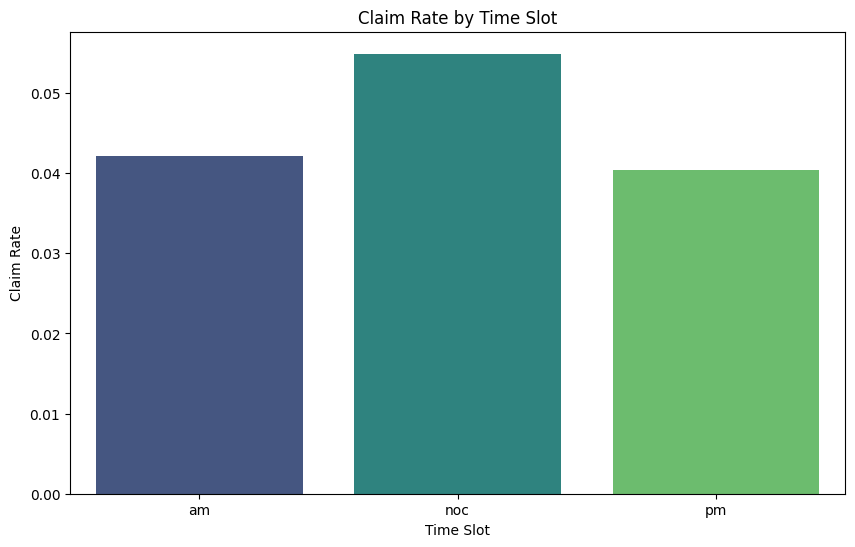

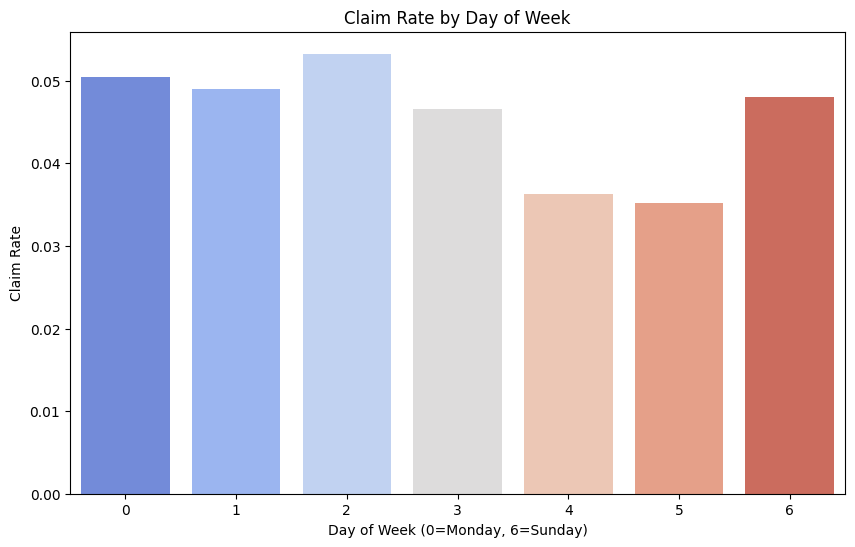

In [ ]:
# 1. Aggregate Data to Analyze Preferences
# Group data by WORKER_ID and SLOT (time slot)
shift_preferences = data.groupby(['WORKER_ID', 'SLOT']).agg(
    total_shifts=('SHIFT_ID', 'count'),  # Total number of shifts viewed
    claimed_shifts=('IS_CLAIMED', 'sum'),  # Total claimed shifts
    avg_pay=('PAY_RATE', 'mean'),  # Average pay rate for the slot
    avg_duration=('DURATION', 'mean')  # Average duration of shifts
).reset_index()

# Calculate claim rate for each worker-slot combination
shift_preferences['claim_rate'] = (
    shift_preferences['claimed_shifts'] / shift_preferences['total_shifts']
)

# 2. Aggregate Preferences Across All Workers (Global Trends)
global_preferences = shift_preferences.groupby('SLOT').agg(
    total_shifts=('total_shifts', 'sum'),
    claimed_shifts=('claimed_shifts', 'sum'),
    avg_pay=('avg_pay', 'mean'),
    avg_duration=('avg_duration', 'mean')
).reset_index()

# Calculate global claim rate per time slot
global_preferences['claim_rate'] = (
    global_preferences['claimed_shifts'] / global_preferences['total_shifts']
)

# 3. Visualize Shift Preferences (Time Slot)
plt.figure(figsize=(10, 6))
sns.barplot(data=global_preferences, x='SLOT', y='claim_rate', palette='viridis')
plt.title('Claim Rate by Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Claim Rate')
plt.show()

# 4. Analyze Day-of-Week Preferences
day_of_week_prefs = data.groupby('DAY_OF_WEEK').agg(
    total_shifts=('SHIFT_ID', 'count'),
    claimed_shifts=('IS_CLAIMED', 'sum'),
    avg_pay=('PAY_RATE', 'mean'),
    avg_duration=('DURATION', 'mean')
).reset_index()

# Calculate claim rate by day of week
day_of_week_prefs['claim_rate'] = (
    day_of_week_prefs['claimed_shifts'] / day_of_week_prefs['total_shifts']
)

# Visualize Day-of-Week Preferences
plt.figure(figsize=(10, 6))
sns.barplot(data=day_of_week_prefs, x='DAY_OF_WEEK', y='claim_rate', palette='coolwarm')
plt.title('Claim Rate by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Claim Rate')
plt.show()



In [ ]:
#Worker Segmentation
worker_features = data.groupby('WORKER_ID').agg(
    total_views=('SHIFT_ID', 'count'),
    claim_rate=('IS_CLAIMED', 'mean'),
    avg_pay=('PAY_RATE', 'mean'),
    avg_duration=('DURATION', 'mean'),
    preferred_slot=('SLOT', lambda x: x.mode()[0] if not x.mode().empty else 'unknown'),
    preferred_day=('DAY_OF_WEEK', lambda x: x.mode()[0] if not x.mode().empty else 'unknown')
).reset_index()


worker_features['claim_rate'] = worker_features['claim_rate'].fillna(0)
worker_features['avg_pay'] = worker_features['avg_pay'].fillna(0)
worker_features['avg_duration'] = worker_features['avg_duration'].fillna(worker_features['avg_duration'].median())


clustering_features = ['total_views', 'claim_rate', 'avg_pay', 'avg_duration']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(worker_features[clustering_features])


kmeans = KMeans(n_clusters=4, random_state=42)
worker_features['cluster'] = kmeans.fit_predict(scaled_features)

# Analyze clusters
print(worker_features.groupby('cluster').mean())


         total_views  claim_rate    avg_pay  avg_duration  preferred_day
cluster                                                                 
0          15.501613    0.004293  23.229214      8.209676       3.352527
1          10.551591    0.007098  27.994939     11.444636       3.242044
2          57.489879    0.351983  24.276462      8.666579       3.991903
3         201.041860    0.045800  22.519998      8.172887       4.727907


/Users/manavjairam/opt/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
